In [3]:
# import module
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random as rn
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

100%|███████████████████████████████████████████████████████████████████████████████| 784/784 [00:01<00:00, 577.93it/s]


4317


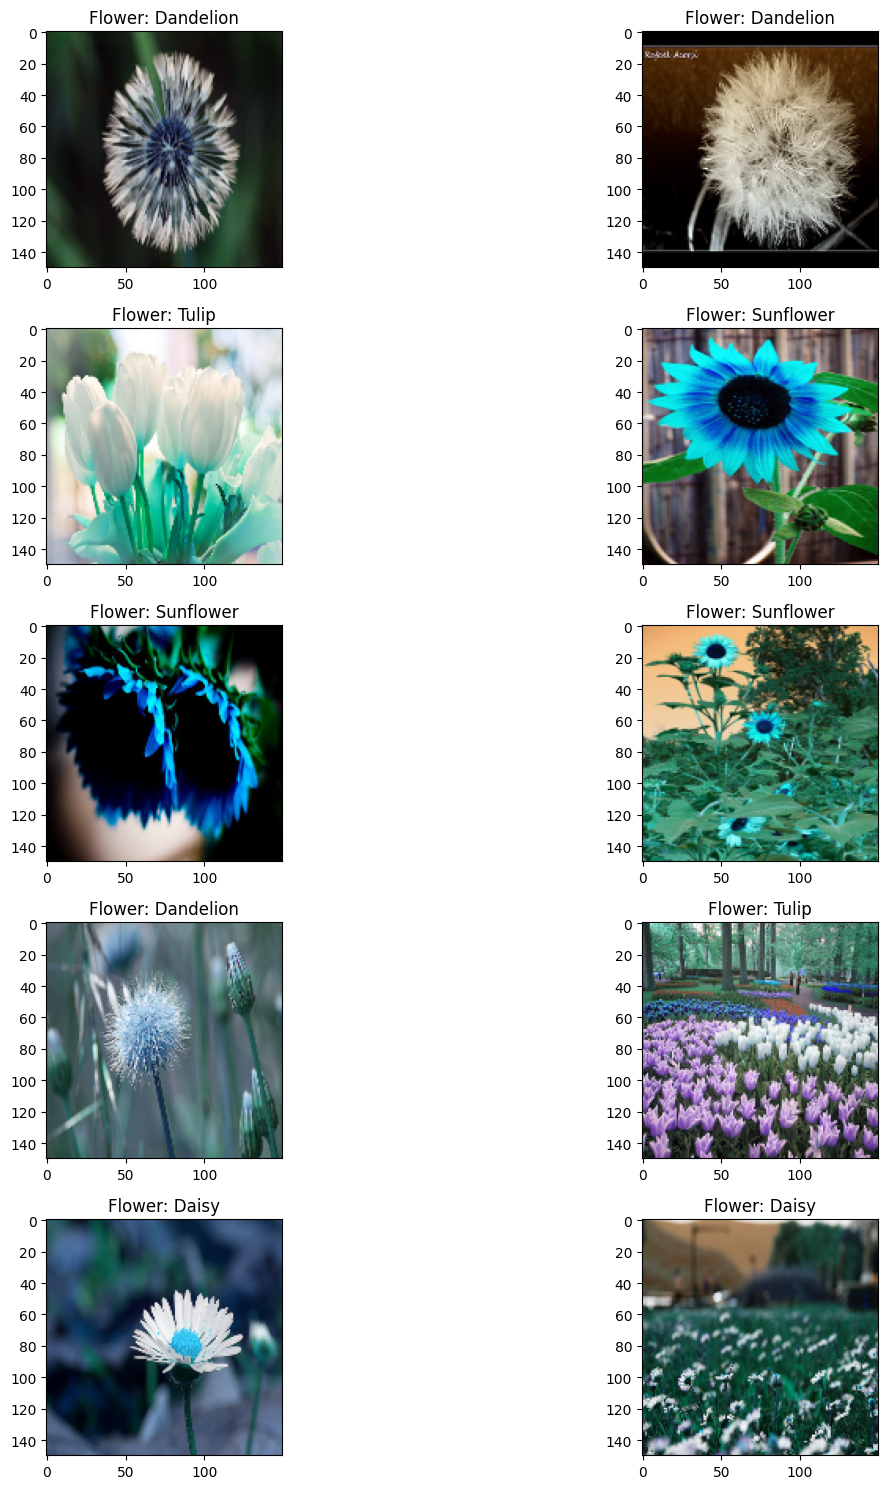

In [4]:
X = []
Z = []
IMG_SIZE = 150

# 設定資料夾相對路徑
FLOWER_DAISY_DIR = 'flowers/daisy'
FLOWER_SUNFLOWER_DIR = 'flowers/sunflower'
FLOWER_TULIP_DIR = 'flowers/tulip'
FLOWER_DANDI_DIR = 'flowers/dandelion'
FLOWER_ROSE_DIR = 'flowers/rose'


# 取得標籤
def assign_label(img,flower_type):
    return flower_type

# 從影像中取得訓練和驗證集
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
          
make_train_data('Daisy',FLOWER_DAISY_DIR)
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip',FLOWER_TULIP_DIR)
make_train_data('Dandelion',FLOWER_DANDI_DIR)
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

# 隨機顯示10張照片及標籤
fig,ax = plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l = rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()


In [5]:
# 資料前處理:將影像標準化及標籤做One-hot Encoding
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/255

# 分割成訓練集和驗證集
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size = 0.7,random_state = 42)

In [6]:
# 設定網路模型架構
inputs = keras.Input(shape = (150,150, 3))
x = layers.Conv2D(32, (3, 3),padding = 'same', activation = 'relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, (3, 3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, (3, 3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation = 'softmax')(x)

# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model = keras.Model(inputs, outputs, name = 'model')

# 設定訓練使用的優化器、損失函數和指標函數
model.compile(optimizer = keras.optimizers.Adam(),loss = 'categorical_crossentropy',metrics = ['accuracy'])

# 顯示網路架構
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856 

In [7]:
# 訓練網路模型
history = model.fit(x_train,y_train,epochs=50,batch_size=128,validation_data = (x_test,y_test))

Epoch 1/50
24/24 [==============================] - 46s 2s/step - loss: 1.4842 - accuracy: 0.3287 - val_loss: 1.2334 - val_accuracy: 0.4745
Epoch 2/50
24/24 [==============================] - 43s 2s/step - loss: 1.2549 - accuracy: 0.4717 - val_loss: 1.0523 - val_accuracy: 0.5764
Epoch 3/50
24/24 [==============================] - 43s 2s/step - loss: 1.1184 - accuracy: 0.5402 - val_loss: 1.0314 - val_accuracy: 0.5910
Epoch 4/50
24/24 [==============================] - 43s 2s/step - loss: 1.0196 - accuracy: 0.6051 - val_loss: 0.9379 - val_accuracy: 0.6265
Epoch 5/50
24/24 [==============================] - 44s 2s/step - loss: 0.9338 - accuracy: 0.6485 - val_loss: 0.8883 - val_accuracy: 0.6466
Epoch 6/50
24/24 [==============================] - 44s 2s/step - loss: 0.8812 - accuracy: 0.6650 - val_loss: 0.8787 - val_accuracy: 0.6451
Epoch 7/50
24/24 [==============================] - 45s 2s/step - loss: 0.8296 - accuracy: 0.6819 - val_loss: 0.8731 - val_accuracy: 0.6651
Epoch 8/50
24/24 [==

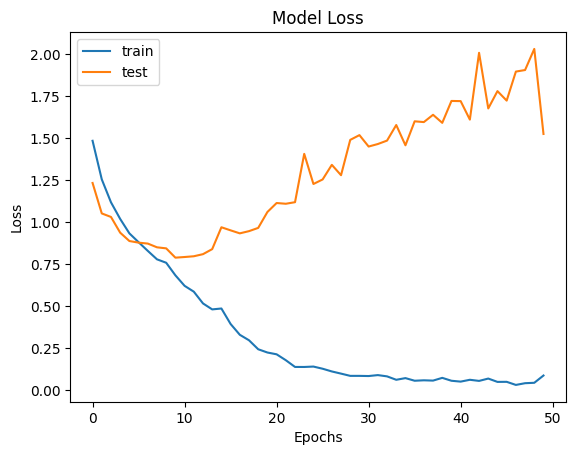

In [8]:
# 透過loss曲線評估模型
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

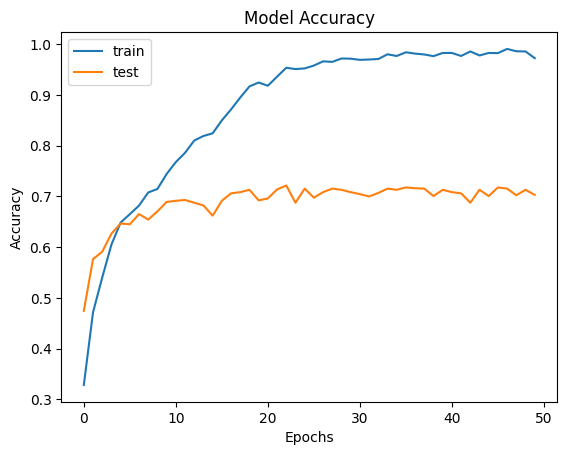

In [9]:
# 透過accuracy曲線評估模型
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

In [13]:
# 預測樣本屬於每個類別的機率
pred = model.predict(x_test)
predict_class = np.argmax(pred,axis=1)

41/41 [==============================] - 4s 97ms/step


In [14]:
# 在y_test隨機取10筆資料
i = 0
random_class = []
for i in range(len(y_test)):
    random_class.append(np.random.randint(len(y_test)))
    if(len(random_class) == 10):
        break
print(random_class)

[1123, 1128, 576, 643, 855, 889, 214, 1171, 364, 934]


1296 1296


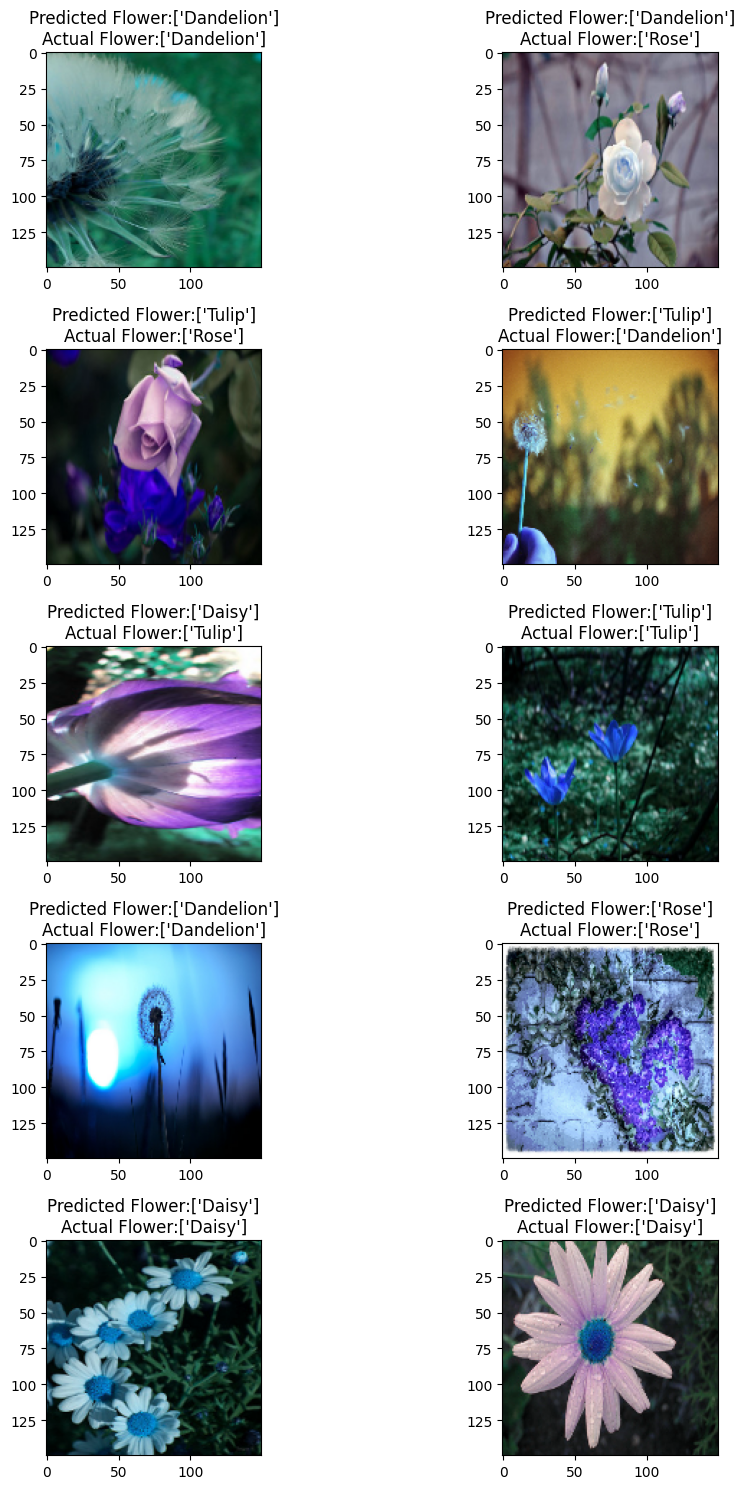

In [15]:
# 將隨機取樣的預測及正解可視化
count = 0
fig,ax = plt.subplots(5,2)
fig.set_size_inches(15,15)
print(len(predict_class),len(y_test))
for i in range (5):
    for j in range (2):
        ax[i,j].imshow(x_test[random_class[count]])
        ax[i,j].set_title("Predicted Flower:" + str(le.inverse_transform([predict_class[random_class[count]]])) + "\n" + "Actual Flower:" + str(le.inverse_transform([np.argmax([y_test[random_class[count]]])])))
        plt.tight_layout()
        count = count + 1